
=== Results (dynamic=False): ===
Astar_Coverage         | Coverage Percentage= 97.97% | Path Length= 1670 | Overlap Count=  465 | Execution Time= 0.486s | Energy Used=  1670 | Covered All Cells=False
Random_Sweep           | Coverage Percentage= 62.23% | Path Length=10000 | Overlap Count= 9235 | Execution Time= 0.037s | Energy Used= 10000 | Covered All Cells=False


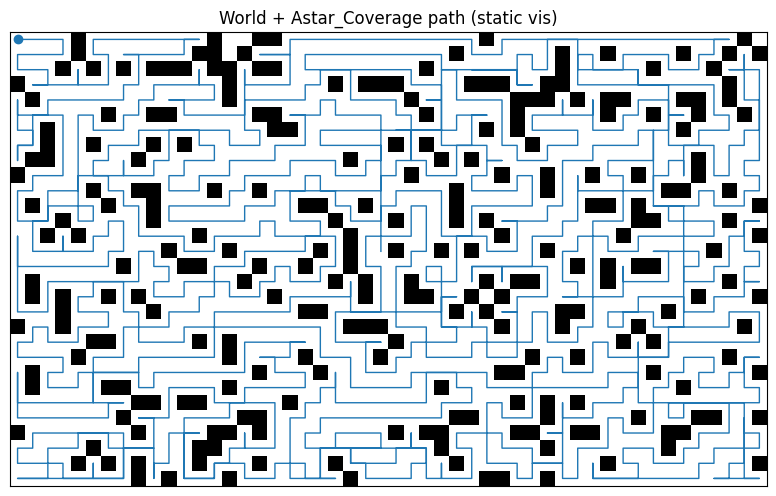


=== Results (dynamic=True): ===
Astar_Coverage         | Coverage Percentage=  5.04% | Path Length=   84 | Overlap Count=   23 | Execution Time= 0.034s | Energy Used=    84 | Covered All Cells=False
Random_Sweep           | Coverage Percentage= 61.98% | Path Length=10000 | Overlap Count= 9238 | Execution Time= 0.168s | Energy Used= 10000 | Covered All Cells=False


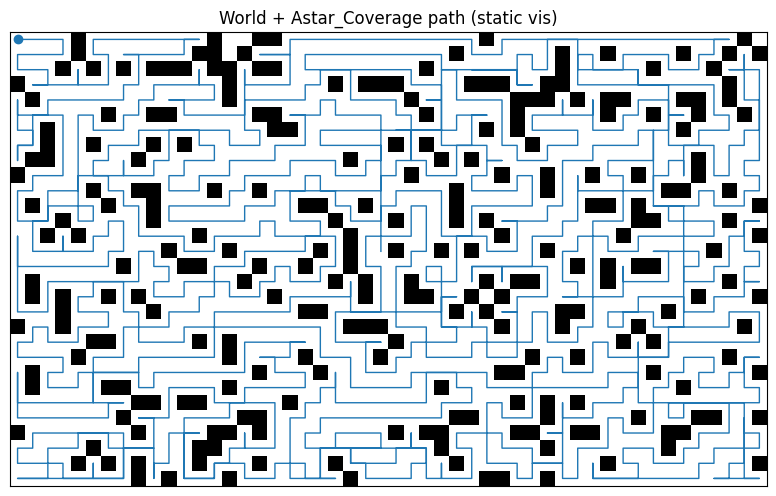

In [8]:
import math
import random
import time
from dataclasses import dataclass, field
from typing import List, Tuple, Optional, Set, Dict
import heapq
# For Grid Representation
import numpy as np
import matplotlib.pyplot as plt

Coord = Tuple[int, int]

# ----------GridWorld Class (The 2D Environment)----------

@dataclass
class GridWorld:
  width: int
  height: int
  ObstacleRatio: float = 0.15 # percentage of cells randomly set as static objects
  seed: int = 0
  DynamicObstacles: int = 0 # Number of moving obstacles
  DynamicMove_Prob: float = 0.2 # Probability that the object moves
  grid: np.ndarray = field(init=False)
  DynamicPositions: List[Coord] = field(default_factory=list) # List of Coordinates for dynamic obstacles

  # Creating Random Static Obstacles
  def __post_init__(self):
    RNG = random.Random(self.seed)
    self.grid = np.zeros((self.height, self.width), dtype=np.uint8)
    # Static obstacles
    NumberOf_Obstacles = int(self.width * self.height * self.ObstacleRatio)
    placed = 0
    while placed < NumberOf_Obstacles:
      r, c = RNG.randrange(self.height), RNG.randrange(self.width)
      if self.grid[r, c] == 0: # free
        self.grid[r, c] = 1  # static obstacle
        placed += 1

    self.grid[0, 0] = 0 # Start cell is always free

    # Dynamic obstacles
    self.DynamicPositions = []
    while len(self.DynamicPositions) < self.DynamicObstacles:
      r, c = RNG.randrange(self.height), RNG.randrange(self.width)
      if self.grid[r, c] == 0 and (r, c) not in self.DynamicPositions and (r, c) != (0,0):
        self.DynamicPositions.append((r,c))


  # --------Helper methods-------


  # Check if Coordinate is inside the grid
  def InBounds(self, p: Coord) -> bool:
    r, c = p
    return 0 <= r < self.height and 0 <= c < self.width

  # Checks if a cell is not an obstacle (dynamic or otherwise)
  def IsFree(self, p: Coord) -> bool:
    r, c = p
    if not self.InBounds(p):
      return False
    if self.grid[r, c] == 1:
      return False
    if p in self.DynamicPositions:
      return False
    return True

  # Returns the 4-connected neighbours (up, down left, right)
  def neighbors4(self, p: Coord) -> List[Coord]:
    r, c = p
    neighbor = [(r+1, c), (r-1, c), (r, c+1), (r, c-1)]
    return [q for q in neighbor if self.InBounds(q)]


  # Moves each dynamic obstacle randomly to an adjacent free cell with DynamicMove_Prob
  def StepForDynamic(self, RNG: random.Random):
    # each dynamic obstacle randomly moves to a free 4-neighbor with some probability
    NewPositions = []
    occupied = set(self.DynamicPositions)
    for position in self.DynamicPositions:
      if RNG.random() < self.DynamicMove_Prob:
        candidates = [q for q in self.neighbors4(position) if self.grid[q] == 0 and q not in occupied]
        if candidates:
          position = RNG.choice(candidates)
      NewPositions.append(position)
    self.DynamicPositions = NewPositions


# --------- UAV Agent & Metrics -------------

# Represents the UAV
# Each move costs MoveCost Energy, and stops when BatteryCapacity is reached
@dataclass
class Agent:
  start: Coord = (0, 0)
  BatteryCapacity: int = 10_000 # Amount of "Energy units"
  MoveCost: int = 1
  path: List[Coord] = field(default_factory=lambda: [(0,0)])
  EnergyUsed: int = 0
# Returns the current positions
  def at(self) -> Coord:
    return self.path[-1]

# Checks if the agent still has enegry
  def CanMove(self) -> bool:
    return (self.EnergyUsed + self.MoveCost) <= self.BatteryCapacity

# Moves the UAV to the next cell, then updates the path and energy used
  def MoveTo(self, p:Coord):
    self.path.append(p)
    self.EnergyUsed += self.MoveCost

# Holds the performance data for a single simulation
@dataclass
class RunMetrics:
  CoveragePercentage: float # CoveragePercentage
  PathLength: int # Path Length
  OverlapCount: int # Overlap Count
  ExecutionTime: float # Execution Time
  EnergyUsed: int # Energy Used
  ReachedAll: bool # Didthe agent cover all reachable cells


# ----------- Utilities -------------

def manhattan(a: Coord, b: Coord) -> int:
    return abs(a[0]-b[0]) + abs(a[1]-b[1])


# Part of Astar search, it's job is to rebuild the path from the start cell to the goal cell (lists path from start cell to goal cell)
def Rebuild_Path(From: Dict[Coord, Coord], goal: Coord) -> List[Coord]:
    current = goal
    rev = [current]
    while current in From:
        current = From[current]
        rev.append(current)
    rev.reverse()
    return rev


def Astar(grid: GridWorld, start: Coord, goal: Coord) -> Optional[List[Coord]]:
    if not grid.IsFree(start) or not grid.IsFree(goal):
        return None
    openh = []
    heapq.heappush(openh, (0 + manhattan(start, goal), 0, start))
    From: Dict[Coord, Coord] = {}
    g = {start: 0}
    visited = set()
    while openh:
        f, cost, current = heapq.heappop(openh)
        if current == goal:
            return Rebuild_Path(From, current)
        if current in visited:
            continue
        visited.add(current)
        for nb in grid.neighbors4(current):
            if not grid.IsFree(nb):
                continue
            newg = cost + 1
            if nb not in g or newg < g[nb]:
                g[nb] = newg
                From[nb] = current
                heapq.heappush(openh, (newg + manhattan(nb, goal), newg, nb))
    return None


# Coverage Planners

def Astar_Coverage(world: GridWorld, agent: Agent, seed: int = 0, dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:
    RNG = random.Random(seed)
    visited = set([agent.at()]) # keeps track of all visited cells
    overlap = 0 # counts revisited cells
    t0 = time.perf_counter() # record start time

    # Builds a mask for all free celss
    Free_Mask = np.zeros_like(world.grid, dtype=bool)
    for r in range(world.height):
        for c in range(world.width):
            if world.grid[r, c] == 0:
                Free_Mask[r, c] = True
    Total_Free = int(Free_Mask.sum()) # Total number of free cells

# Main loop: Keep looping until the agent still has battery, until the step count isn't exceeded and time doesn't run out
    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:  # stop after 5 seconds
            break
        if dynamic:
            world.StepForDynamic(RNG)

      # Find nearest unvisited target
        current = agent.at()
        targets: List[Tuple[int, Coord]] = []
        for r in range(world.height):
            for c in range(world.width):
                p = (r, c)
                if Free_Mask[r, c] and p not in visited:
                    targets.append((manhattan(current, p), p))
        if not targets:
            break
        targets.sort(key=lambda x: x[0])

        path = None
        for _, goal in targets[:500]:  # try nearest few
            path = Astar(world, current, goal)
            if path:
                break

        if not path:  # no reachable unvisited cell (blocked by obstacles/dynamics)
            break

        # Follow the path step-by-step
        for nxt in path[1:]:
            if dynamic and not world.IsFree(nxt):
                # Need to replan from current position
                break
            if not agent.CanMove():
                break # out of battery
            Prev_len = len(visited)
            if nxt in visited:
                overlap += 1
            agent.MoveTo(nxt)
            visited.add(nxt)
            steps += 1

    t1 = time.perf_counter()
    covered = len(visited)
    CoveragePercentage = 100.0 * covered / max(1, Total_Free)
    return RunMetrics(
        CoveragePercentage=CoveragePercentage,
        PathLength=len(agent.path)-1,
        OverlapCount=overlap,
        ExecutionTime=t1 - t0,
        EnergyUsed=agent.EnergyUsed,
        ReachedAll=(CoveragePercentage >= 99.9)
    )


def RandomSweep(world: GridWorld, agent: Agent, seed: int = 0,
                 dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:
    RNG = random.Random(seed)
    visited = set([agent.at()])
    overlap = 0
    t0 = time.perf_counter()

    Free_Mask = (world.grid == 0)
    Total_Free = int(Free_Mask.sum())

    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:  # stop after 5 seconds
            break
        if dynamic:
            world.StepForDynamic(RNG)
        current = agent.at()
        moves = [p for p in world.neighbors4(current) if world.IsFree(p)]
        if not moves:
            break
        nxt = RNG.choice(moves)
        if nxt in visited:
            overlap += 1
        agent.MoveTo(nxt)
        visited.add(nxt)
        steps += 1
        if len(visited) >= Total_Free:
            break

    t1 = time.perf_counter()
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    return RunMetrics(
        CoveragePercentage=CoveragePercentage,
        PathLength=len(agent.path)-1,
        OverlapCount=overlap,
        ExecutionTime=t1 - t0,
        EnergyUsed=agent.EnergyUsed,
        ReachedAll=(CoveragePercentage >= 99.9)
    )

# Algorithms

def SimulatedAnnealing(world: GridWorld, agent: Agent, **kwargs) -> RunMetrics:
  return Astar_coverage(world, agent, **kwargs)

def AntColony(world: GridWorld, agent: Agent, **kwargs) -> RunMetrics:
  return Astar_coverage(world, agent, **kwargs)

def GeneticAlgorithm(world: GridWorld, agent: Agent, **kwargs) -> RunMetrics:
  return Astar_coverage(world, agent, **kwargs)

# Particle Swarm Optimisation
def PSO(world: GridWorld, agent: Agent, **kwargs) -> RunMetrics:
    return nearest_frontier_astar(world, agent, **kwargs)



def run_experiment(width=50, height=30, ObstacleRatio=0.18, DynamicObstacles=20,
                   dynamic=False, seed=7):
  # Creates grid world
    world = GridWorld(width=width, height=height, ObstacleRatio=ObstacleRatio,seed=seed, DynamicObstacles=DynamicObstacles,DynamicMove_Prob=0.25)

    # Algorithm dictionary
    Algs = {
        "Astar_Coverage": Astar_Coverage,
        "Random_Sweep": RandomSweep,
        # Future: enable these once implemented
        # "Simulated_Annealing": SimulatedAnnealing,
        # "Ant_Colony_Opt": AntColony,
        # "Genetic_Alg": GeneticAlgorithm,
        # "PSO": pso_coverage,
    }

   # Running each algorithm
    results: Dict[str, RunMetrics] = {}
    for name, fn in Algs.items():
        agent = Agent(start=(0, 0), BatteryCapacity=10_000, MoveCost=1)
        WorldCopy = GridWorld(width=world.width, height=world.height,
                               ObstacleRatio=0.0, seed=seed,
                               DynamicObstacles=world.DynamicObstacles,
                               DynamicMove_Prob=world.DynamicMove_Prob)
        # copy static grid & dynamic positions
        WorldCopy.grid = world.grid.copy()
        WorldCopy.DynamicPositions = list(world.DynamicPositions)
        metrics = fn(WorldCopy, agent, seed=seed, dynamic=dynamic)
        results[name] = metrics

    # Print table
    print("\n=== Results (dynamic={}): ===".format(dynamic))
    for k, m in results.items():
        print(f"{k:22s} | Coverage Percentage={m.CoveragePercentage:6.2f}% | "
              f"Path Length={m.PathLength:5d} | Overlap Count={m.OverlapCount:5d} | "
              f"Execution Time={m.ExecutionTime:6.3f}s | Energy Used={m.EnergyUsed:6d} | "
              f"Covered All Cells={m.ReachedAll}")

    # Visualise
    vis_key = "Astar_Coverage"
    agent_vis = Agent()
    # Re-run for path capture
    world_vis = GridWorld(width=world.width, height=world.height,
                          ObstacleRatio=0.0, seed=seed,
                          DynamicObstacles=0, DynamicMove_Prob=world.DynamicMove_Prob)
    world_vis.grid = world.grid.copy()
    world_vis.DynamicPositions = []
    _ = Astar_Coverage(world_vis, agent_vis, seed=seed, dynamic=False)


    # Creating Plot of the world
    fig, ax = plt.subplots(figsize=(8, 5))
    img = np.where(world.grid == 1, 0.2, 1.0)
    ax.imshow(img, cmap="gray", origin="upper")
    ys = [p[0] for p in agent_vis.path]
    xs = [p[1] for p in agent_vis.path]
    ax.plot(xs, ys, linewidth=1.0)
    ax.scatter([0], [0], marker="o")  # start
    ax.set_title(f"World + {vis_key} path (static vis)")
    ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    plt.show()

# Execution
if __name__ == "__main__":
    # Static first, then dynamic toggle
    run_experiment(dynamic=False)
    run_experiment(dynamic=True)
